In [3]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.6.0


In [6]:
train_data=pd.read_csv('../data/kaggle_house/train.csv')
test_data=pd.read_csv('../data/kaggle_house/test.csv')

In [7]:
train_data.shape

(1460, 81)

In [8]:
test_data.shape

(1459, 80)

In [34]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [35]:
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [36]:
numeric_features=all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
all_features[numeric_features]=all_features[numeric_features].fillna(0)

In [37]:
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 331)

In [38]:
train_data.shape

(1460, 81)

In [39]:
all_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,-2.069222,-1.043758,-1.481667,1.289537,-0.043338,-0.682695,-0.569893,-0.968860,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1455,2.419286,-2.069222,-1.049083,-1.481667,-0.507197,-0.043338,-0.682695,-0.569893,-0.415757,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1456,-0.873466,3.884968,1.246594,-0.772420,1.289537,-0.373465,0.561660,-0.569893,1.717643,-0.29303,...,0,1,0,1,0,0,0,0,0,0
1457,0.655311,-0.312950,0.034599,-0.772420,-0.507197,0.682939,0.370221,-0.569893,-0.229194,-0.29303,...,0,1,0,0,0,0,0,1,0,0


In [40]:
n_train=train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels=torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

In [61]:
loss=torch.nn.MSELoss()

def get_net(features_num):
    net=nn.Linear(features_num,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

In [79]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()


In [84]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    dataset=torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    optimizer=torch.optim.Adam(params=net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    net=net.float()
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [85]:
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0] //k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        if j==i:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        else:
            X_train=torch.cat((X_train,X_part),dim=0)
            y_train=torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid

In [90]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net(X_train.shape[1])
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse',
                        range(1,num_epochs+1),valid_ls,['train','valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

fold 0, train rmse 0.170308, valid rmse 0.156921
fold 1, train rmse 0.162422, valid rmse 0.191565
fold 2, train rmse 0.163559, valid rmse 0.168132
fold 3, train rmse 0.168184, valid rmse 0.154584
fold 4, train rmse 0.162687, valid rmse 0.182736
5-fold validation: avg train rmse 0.165432, avg valid rmse 0.170788


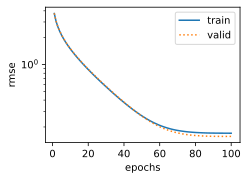

In [91]:
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k,train_l,valid_l))

In [92]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net=get_net(train_features.shape[1])
    train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse')
    print('train rmse %f' % train_ls[-1])
    preds=net(test_features).detach().numpy()
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('./submission.csv',index=False)

train rmse 0.162613


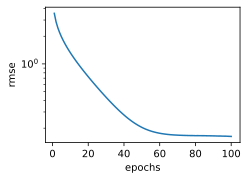

In [93]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)